# MNIST 


/home/radio/herlock/.venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



[Seed 0]
  Round 0
  Round 100
  Round 200
  Round 300
  Round 400
  Round 500
  Round 600
  Round 700
  Round 800
  Round 900
  Round 1000
  Round 1100
  Round 1200
  Round 1300
  Round 1400
  Round 1500
  Round 1600
  Round 1700
  Round 1800
  Round 1900

[Seed 1]
  Round 0
  Round 100
  Round 200
  Round 300
  Round 400
  Round 500
  Round 600
  Round 700
  Round 800
  Round 900
  Round 1000
  Round 1100
  Round 1200
  Round 1300
  Round 1400
  Round 1500
  Round 1600
  Round 1700
  Round 1800
  Round 1900

[Seed 2]
  Round 0
  Round 100
  Round 200
  Round 300
  Round 400
  Round 500
  Round 600
  Round 700
  Round 800
  Round 900
  Round 1000
  Round 1100
  Round 1200
  Round 1300
  Round 1400
  Round 1500
  Round 1600
  Round 1700
  Round 1800
  Round 1900

[Seed 3]
  Round 0
  Round 100
  Round 200
  Round 300
  Round 400
  Round 500
  Round 600
  Round 700
  Round 800
  Round 900
  Round 1000
  Round 1100
  Round 1200
  Round 1300
  Round 1400
  Round 1500
  Round 1600
  Round

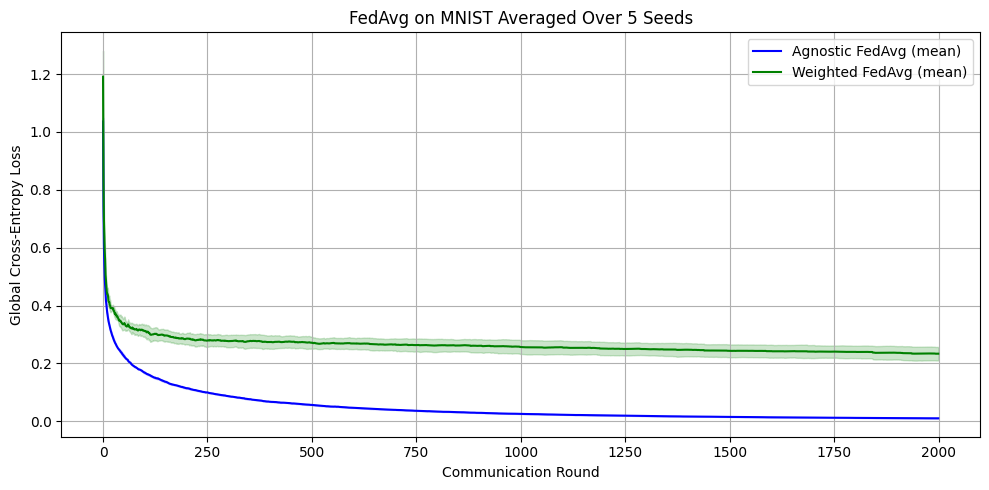

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

# --- Experiment Configuration ---
NUM_USERS = 100
NUM_CLASSES = 10
M = 10  # Users per round
ROUNDS = 2000
LOCAL_EPOCHS = 10
DIM = 784
SAMPLES_PER_USER = 3000 // NUM_USERS
LR = 0.1
SEEDS = [0, 1, 2, 3, 4]

# --- Fetch MNIST once ---
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X_full, y_full = mnist.data / 255.0, mnist.target.astype(int)
X_full = X_full[:3000]
y_full = y_full[:3000]
X_full = StandardScaler().fit_transform(X_full)

# --- Storage ---
all_losses_agnostic = []
all_losses_weighted = []

for seed in SEEDS:
    np.random.seed(seed)
    print(f"\n[Seed {seed}]")

    # --- Partition MNIST data across users ---
    perm = np.random.permutation(len(X_full))
    X = X_full[perm]
    y = y_full[perm]
    user_data = [
        (X[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER],
         y[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER])
        for i in range(NUM_USERS)
    ]

    # --- Approximate marginal p_i via sampling ---
    # --- Create a skewed user distribution q ---
    #    Exa mple: Exponentially decreasing probabilities
    q = np.array([np.exp(-i / 10) for i in range(NUM_USERS)])
    q /= q.sum()

    # --- Approximate marginal p_i by biased sampling using q ---
    p_i = np.zeros(NUM_USERS)
    approx_rounds = 20000
    for _ in range(approx_rounds):
        subset = np.random.choice(NUM_USERS, M, replace=False, p=q)
        for i in subset:
            p_i[i] += 1
    p_i /= p_i.sum()

    # --- Helper functions ---
    def softmax(z):
        z -= np.max(z, axis=1, keepdims=True)
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def local_train(X, y, weights, epochs=1, lr=0.1):
        for _ in range(epochs):
            logits = X @ weights
            probs = softmax(logits)
            one_hot = np.eye(NUM_CLASSES)[y]
            grad = X.T @ (probs - one_hot) / len(y)
            weights -= lr * grad
        return weights

    def global_loss(global_weights):
        losses = []
        for X_u, y_u in user_data:
            logits = X_u @ global_weights
            probs = softmax(logits)
            losses.append(log_loss(y_u, probs, labels=np.arange(NUM_CLASSES)))
        return np.mean(losses)

    # --- Initialization ---
    global_weights_agnostic = np.zeros((DIM, NUM_CLASSES))
    global_weights_weighted = np.zeros((DIM, NUM_CLASSES))
    losses_agnostic = []
    losses_weighted = []

    # --- Training Loop ---
    for r in range(ROUNDS):
        if r % 100 == 0:
            print(f"  Round {r}")

        selected_users = np.random.choice(NUM_USERS, M, replace=False)

        # --- Agnostic FedAvg ---
        local_models = []
        for user in selected_users:
            X_u, y_u = user_data[user]
            w_local = global_weights_agnostic.copy()
            w_local = local_train(X_u, y_u, w_local, epochs=LOCAL_EPOCHS, lr=LR)
            local_models.append(w_local)
        global_weights_agnostic = np.mean(local_models, axis=0)
        losses_agnostic.append(global_loss(global_weights_agnostic))

        # --- Weighted FedAvg ---
        local_models = []
        weight_factors = []
        for user in selected_users:
            X_u, y_u = user_data[user]
            w_local = global_weights_weighted.copy()
            w_local = local_train(X_u, y_u, w_local, epochs=LOCAL_EPOCHS, lr=LR)
            local_models.append(w_local)
            weight_factors.append((p_i[user] / M) * NUM_USERS)
        weighted_sum = sum(w * f for w, f in zip(local_models, weight_factors))
        global_weights_weighted = weighted_sum / sum(weight_factors)
        losses_weighted.append(global_loss(global_weights_weighted))

    all_losses_agnostic.append(losses_agnostic)
    all_losses_weighted.append(losses_weighted)

# --- Convert to Arrays ---
all_losses_agnostic = np.array(all_losses_agnostic)
all_losses_weighted = np.array(all_losses_weighted)

# --- Compute Mean ± Std ---
mean_agnostic = all_losses_agnostic.mean(axis=0)
std_agnostic = all_losses_agnostic.std(axis=0)
mean_weighted = all_losses_weighted.mean(axis=0)
std_weighted = all_losses_weighted.std(axis=0)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(mean_agnostic, label='Agnostic FedAvg (mean)', color='blue')
plt.fill_between(range(ROUNDS), mean_agnostic - std_agnostic, mean_agnostic + std_agnostic, color='blue', alpha=0.2)

plt.plot(mean_weighted, label='Weighted FedAvg (mean)', color='green')
plt.fill_between(range(ROUNDS), mean_weighted - std_weighted, mean_weighted + std_weighted, color='green', alpha=0.2)

plt.xlabel('Communication Round')
plt.ylabel('Global Cross-Entropy Loss')
plt.title(f'FedAvg on MNIST Averaged Over {len(SEEDS)} Seeds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# --- Scatter Plot: L1 vs Loss Gap ---
plt.figure(figsize=(6, 4))
plt.scatter(l1_distances, loss_differences, color='purple')
for i, (x, y) in enumerate(zip(l1_distances, loss_differences)):
    plt.text(x + 0.001, y, f"Seed {SEEDS[i]}", fontsize=10)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("L1 Distance from Uniform $||p_i - u||_1$", fontsize=20)
plt.ylabel("Final Loss Difference\n(Weighted - Agnostic)", fontsize=20)
plt.title("Loss Difference vs. Participation Skew (MNIST)", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'l1_distances' is not defined

<Figure size 600x400 with 0 Axes>

# Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# --- Experiment Configuration ---
NUM_USERS = 100
M = 10  # Users per communication round
ROUNDS = 2000
LOCAL_EPOCHS = 10
DIM = 200
SAMPLES_PER_USER = 3000 // NUM_USERS
LR = 0.01
SEEDS = [0, 1, 2, 3, 5]

# --- Storage ---
all_losses_agnostic_lr = []
all_losses_weighted_lr = []
l1_distances_lr = []
loss_differences_lr = []

for seed in SEEDS:
    print(f"we are in seed {seed}")

    np.random.seed(seed)

    # --- Generate Regression Data ---
    X_full, y_full = make_regression(n_samples=3000, n_features=DIM, noise=0.1, random_state=seed)
    X_full = StandardScaler().fit_transform(X_full)

    # --- Partition to users ---
    perm = np.random.permutation(len(X_full))
    X = X_full[perm]
    y = y_full[perm]
    user_data = [
        (X[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER],
         y[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER])
        for i in range(NUM_USERS)
    ]

    # --- Subset Sampling Distribution ---
    all_subsets = list(combinations(range(NUM_USERS), M))
    num_subsets = len(all_subsets)
    num_chosen_subsets = 5
    chosen_indices = np.random.choice(num_subsets, num_chosen_subsets, replace=False)
    subset_weights = np.full(num_subsets, 1e-10)
    chosen_weights = np.random.dirichlet(np.ones(num_chosen_subsets))
    subset_weights[chosen_indices] = chosen_weights
    subset_weights /= subset_weights.sum()

    # --- Compute Marginal p_i ---
    p_i = np.zeros(NUM_USERS)
    for subset, weight in zip(all_subsets, subset_weights):
        for i in subset:
            p_i[i] += weight / M

    # --- Helper Functions ---
    def local_train(X, y, weights, epochs=1, lr=0.01):
        for _ in range(epochs):
            preds = X @ weights
            grad = X.T @ (preds - y) / len(y)
            weights -= lr * grad
        return weights

    def global_loss(global_weights):
        losses = []
        for X_u, y_u in user_data:
            preds = X_u @ global_weights
            loss = mean_squared_error(y_u, preds)
            losses.append(loss)
        return np.mean(losses)

    # --- Init Weights ---
    global_weights_agnostic = np.zeros(DIM)
    global_weights_weighted = np.zeros(DIM)
    losses_agnostic = []
    losses_weighted = []

    # --- Training Loop ---
    for r in range(ROUNDS):
        print(f"we are in round {r}")

        subset_idx = np.random.choice(len(all_subsets), p=subset_weights)
        selected_users = all_subsets[subset_idx]

        # --- Agnostic FedAvg ---
        local_models = []
        for user in selected_users:
            X_u, y_u = user_data[user]
            w_local = global_weights_agnostic.copy()
            w_local = local_train(X_u, y_u, w_local, epochs=LOCAL_EPOCHS, lr=LR)
            local_models.append(w_local)
        global_weights_agnostic = np.mean(local_models, axis=0)
        losses_agnostic.append(global_loss(global_weights_agnostic))

        # --- Weighted FedAvg ---
        local_models = []
        weight_factors = []
        for user in selected_users:
            X_u, y_u = user_data[user]
            w_local = global_weights_weighted.copy()
            w_local = local_train(X_u, y_u, w_local, epochs=LOCAL_EPOCHS, lr=LR)
            local_models.append(w_local)
            weight_factors.append((p_i[user] / M) * NUM_USERS)
        weighted_sum = sum(w * f for w, f in zip(local_models, weight_factors))
        global_weights_weighted = weighted_sum / sum(weight_factors)
        losses_weighted.append(global_loss(global_weights_weighted))

    all_losses_agnostic_lr.append(losses_agnostic)
    all_losses_weighted_lr.append(losses_weighted)

    # --- L1 Distance and Loss Gap ---
    uniform_p = np.full(NUM_USERS, 1 / NUM_USERS)
    l1_distances_lr.append(np.sum(np.abs(p_i - uniform_p)))
    loss_differences_lr.append(losses_weighted[-1] - losses_agnostic[-1])

# --- Convert to Arrays ---
all_losses_agnostic_lr = np.array(all_losses_agnostic_lr)
all_losses_weighted_lr = np.array(all_losses_weighted_lr)
l1_distances_lr = np.array(l1_distances_lr)
loss_differences_lr = np.array(loss_differences_lr)
# --- Truncate for plotting ---
start = 100
end = 1000
x_range = np.arange(start, end)

# --- Compute Mean ± Std ---
mean_agnostic_lr = all_losses_agnostic_lr.mean(axis=0)[start:end]
std_agnostic_lr= all_losses_agnostic_lr.std(axis=0)[start:end]
mean_weighted_lr = all_losses_weighted_lr.mean(axis=0)[start:end]
std_weighted_lr = all_losses_weighted_lr.std(axis=0)[start:end]

# --- Log Scale Plot ---
plt.figure(figsize=(10, 5))
plt.plot(x_range, mean_agnostic_lr, label='Agnostic FedAvg (mean)', color='blue')
# plt.fill_between(x_range, mean_agnostic - std_agnostic, mean_agnostic + std_agnostic, color='blue', alpha=0.2)

plt.plot(x_range, mean_weighted_lr, label='Weighted FedAvg (mean)', color='green')
# plt.fill_between(x_range, mean_weighted - std_weighted, mean_weighted + std_weighted, color='green', alpha=0.2)

plt.yscale('log')
plt.xlabel('Communication Round')
plt.ylabel('Global MSE Loss (log scale)')
plt.title(f'FedAvg Convergence (Rounds {start}-{end}, Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
# --- Correlation Report ---
corr = np.corrcoef(l1_distances_lr, loss_differences_lr)[0, 1]
print(f"\nCorrelation between skew (L1 distance) and loss gap: {corr:.4f}")

we are in seed 0


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd445e38580>>
Traceback (most recent call last):
  File "/home/radio/herlock/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


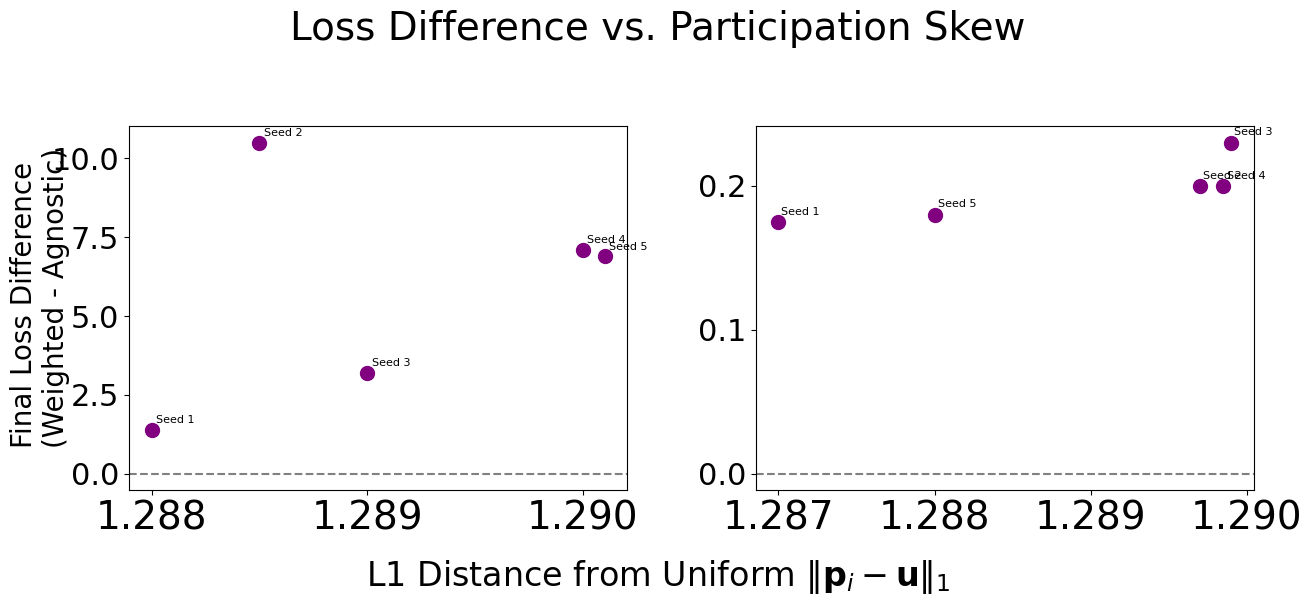

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# --- Style config ---
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 30,
    'axes.labelsize': 22,
    'xtick.labelsize': 28,
    'ytick.labelsize': 22,
    'legend.fontsize': 20
})

# --- Example data ---
l1_distances_lr = np.array([1.288, 1.2885, 1.289, 1.29, 1.2901])
loss_diffs_lr = np.array([1.4, 10.5, 3.2, 7.1, 6.9])
seeds_lr = ['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5']

l1_distances_mnist = np.array([1.2870, 1.2897, 1.2899, 1.28985, 1.2880])
loss_diffs_mnist = np.array([0.175, 0.20, 0.23, 0.20, 0.18])
seeds_mnist = ['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5']

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(13.5, 6), sharex=False, sharey=False)

# Subplot 1: Linear Regression
axs[0].scatter(l1_distances_lr, loss_diffs_lr, color='purple', s=100)
for i, seed in enumerate(seeds_lr):
    axs[0].text(l1_distances_lr[i]+0.00002, loss_diffs_lr[i]+0.2, seed, fontsize=8)
axs[0].axhline(y=0, color='gray', linestyle='--')

# Subplot 2: MNIST
axs[1].scatter(l1_distances_mnist, loss_diffs_mnist, color='purple', s=100)
for i, seed in enumerate(seeds_mnist):
    axs[1].text(l1_distances_mnist[i]+0.00002, loss_diffs_mnist[i]+0.005, seed, fontsize=8)
axs[1].axhline(y=0, color='gray', linestyle='--')

# --- Shared labels and title ---
fig.suptitle("Loss Difference vs. Participation Skew", fontsize=28)
fig.text(0.5, 0.02, r"L1 Distance from Uniform $\|\mathbf{p}_i - \mathbf{u}\|_1$", ha='center', fontsize=24)
fig.text(0.02, 0.5, "Final Loss Difference\n(Weighted - Agnostic)", va='center', rotation='vertical', fontsize=20)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # leave space for suptitle
plt.savefig("combined_loss_vs_skew_shared_title.png", dpi=300)
plt.show()